## Make PCTS data tract level

In [1]:
import intake
import geopandas as gpd
import numpy as np
import pandas as pd

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

bucket_name = 'city-planning-entitlements'

## Import data

In [3]:
census = pd.read_parquet(f's3://{bucket_name}/data/final/census_analysis_table.parquet')

In [4]:
crosswalk_parcels_tracts = pd.read_parquet(f's3://{bucket_name}/data/crosswalk_parcels_tracts.parquet')

# Find the number of parcels within tract (but drop duplicate geometries first)
subset_cols = ['num_AIN', 'parcelsqft', 'parcel_tot', 'TOC_Tier', 'GEOID']
no_dups = crosswalk_parcels_tracts.drop_duplicates(subset = subset_cols, keep = 'first')

num_AIN_by_tract = (no_dups.groupby(['GEOID'])
                    .agg({'AIN':'count'})
                    .reset_index()
                    .rename(columns = {'AIN': 'tot_parcels'})
                   )

crosswalk_parcels_tracts = pd.merge(crosswalk_parcels_tracts, num_AIN_by_tract, 
                                    on = 'GEOID', how = 'left', validate = 'm:1')

keep = ['AIN', 'tot_parcels', 'GEOID', 'pop']
crosswalk_parcels_tracts = crosswalk_parcels_tracts[keep]

## Make PCTS tract-level
* Aggregate and count the number of unique parent cases, number of parcels with ENT, and number of ENT with each suffix by tract

In [5]:
def make_tract_level(start_date):
    # Import data
    pcts = pd.read_parquet(f's3://{bucket_name}/data/final/master_pcts.parquet')
    parents = pd.read_parquet(f's3://{bucket_name}/data/final/parents_with_suffix.parquet')
    
    # Subset PCTS, we'll start with last 10 years
    pcts = pcts[pcts.CASE_FILE_DATE >= start_date]
    
    # (1a) Only keep parent cases
    m1 = pd.merge(pcts, parents, on = 'PARENT_CASE', how = 'inner', validate = 'm:1')

    # (1b) Make cases parcel-level
    parents_by_parcel = (m1.groupby(['AIN'])
                         .agg({'PARENT_CASE':'count'})
                         .reset_index()
                         .rename(columns = {'PARENT_CASE':'num_cases'})
                        )

    # (1c) Merge in tract info and aggregate to tract-level
    m2 = pd.merge(parents_by_parcel, crosswalk_parcels_tracts, on = 'AIN', how = 'inner', validate = '1:1')

    # Even though the column num_AIN shows there are some parcels with more than 1 obs,
    # once we merged in parent cases, no AIN shows up more than once

    ent_by_tract = m2.groupby(['GEOID', 'pop']).agg({'num_cases':'sum', 'AIN':'count'}).reset_index()
    
    
    # (2a) Only keep suffixes
    suffix = m1.loc[:, '1A':'ZV']
    
    m3 = pd.merge(m1[['AIN']], suffix, left_index = True, right_index = True)

    # (2b) Make suffixes parcel-level
    suffix_by_parcel = (m3.pivot_table(index = 'AIN', aggfunc = 'sum')
                        .reset_index()
                       )

    # (2c) Merge in tract info and aggregate to tract-level
    m4 = pd.merge(suffix_by_parcel, crosswalk_parcels_tracts, 
                                 on = 'AIN', how = 'left', validate = '1:1')

    # Aggregate the number of suffixes by tract
    suffix_by_tract = m4.pivot_table(index = ['GEOID', 'pop'], aggfunc = 'sum').reset_index()
    
    
    # (3) Merge number of cases and suffixes by tract
    df = pd.merge(ent_by_tract, suffix_by_tract, on = ['GEOID', 'pop'], how = 'left', validate = '1:1')
        
    # (4) Make sure everything returns as integers and not floats
    colnames = list(df.columns)

    for r in ['GEOID', 'pop', 'AIN']:
        colnames.remove(r)
    
    # Count number of suffixes, since each ENT can have any number of suffixes involved
    df[colnames] = df[colnames].fillna(0).astype(int) 
    df['num_suffix'] = df[colnames].sum(axis=1)
        
    return df

In [6]:
start_date = "2010-01"
df = make_tract_level(start_date)

In [7]:
df = pd.merge(df, census, on = 'GEOID', how = 'left', validate = '1:1')
df.head()

,GEOID,pop,num_cases,AIN,1A,2A,A,AC,ACI,ADD1,...,ZCJ,ZV,tot_parcels,num_suffix,p_renter,p_zero_veh,p_transit,p_nonwhite,p_low_income_total,p_low_income_nonwhite
0,06037101110,4566,20,10,0,0,0,0,0,0,...,0,2,11640,11690,0.521214,NaN,0.053970,0.231803,0.496241,0.459930
1,06037101122,3064,11,7,0,0,0,0,0,0,...,0,0,9212,9235,0.178417,146.692308,0.009963,0.124112,0.184713,0.186567
2,06037101210,6043,68,36,0,0,0,0,0,0,...,0,1,18828,18976,0.876399,11.169355,0.135740,0.211666,0.677725,0.560870
3,06037101220,3340,20,14,2,0,0,0,0,0,...,0,0,9674,9717,0.603374,12.007937,0.083278,0.286817,0.649923,0.485175
4,06037101300,4285,35,17,1,0,0,1,0,0,...,0,0,23919,23995,0.083059,97.190476,0.088192,0.137771,0.303833,0.144654


In [8]:
df.to_parquet(f's3://{bucket_name}/data/final/pcts_with_census.parquet')

## Export a table to use in Tableau

In [17]:
df = pd.read_parquet(f's3://{bucket_name}/data/final/pcts_with_census.parquet')
tracts = catalog.census_tracts.read()

In [18]:
df = pd.merge(df, tracts[['GEOID10', 'geometry']], 
              left_on = 'GEOID', right_on = 'GEOID10', how = 'inner', validate = 'm:1')

In [19]:
df = gpd.GeoDataFrame(df)
df.crs = {'init':'epsg:2229'}

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


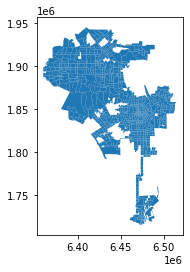

In [16]:
df.plot()

In [20]:
df.to_crs({'init':'epsg:4326'}).to_file(driver = 'ESRI Shapefile', filename = '../gis/final/test_tableau')

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
